In [1]:
# import nessesary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import re

from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import folium
from folium.plugins import FastMarkerCluster

!pip install geopandas
import geopandas as gpd
!pip install squarify
import squarify 

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# import data
lst = pd.read_csv('https://www.dropbox.com/s/i7v9bqasvvgk0vw/listings.csv?dl=1')
lst_scr = pd.read_csv('https://www.dropbox.com/s/aqeqegpam19ygyv/listings.csv.gz?dl=1',compression='gzip')
cld = pd.read_csv('https://www.dropbox.com/s/za3oy6me4k4r4wz/calendar.csv.gz?dl=1',compression='gzip')
cmt = pd.read_csv('https://www.dropbox.com/s/wga1ibnhgczl4bl/reviews.csv.gz?dl=1',compression='gzip')
loc = gpd.read_file('https://www.dropbox.com/s/3pxlvrql5x7ny1h/neighbourhoods.geojson?dl=1')

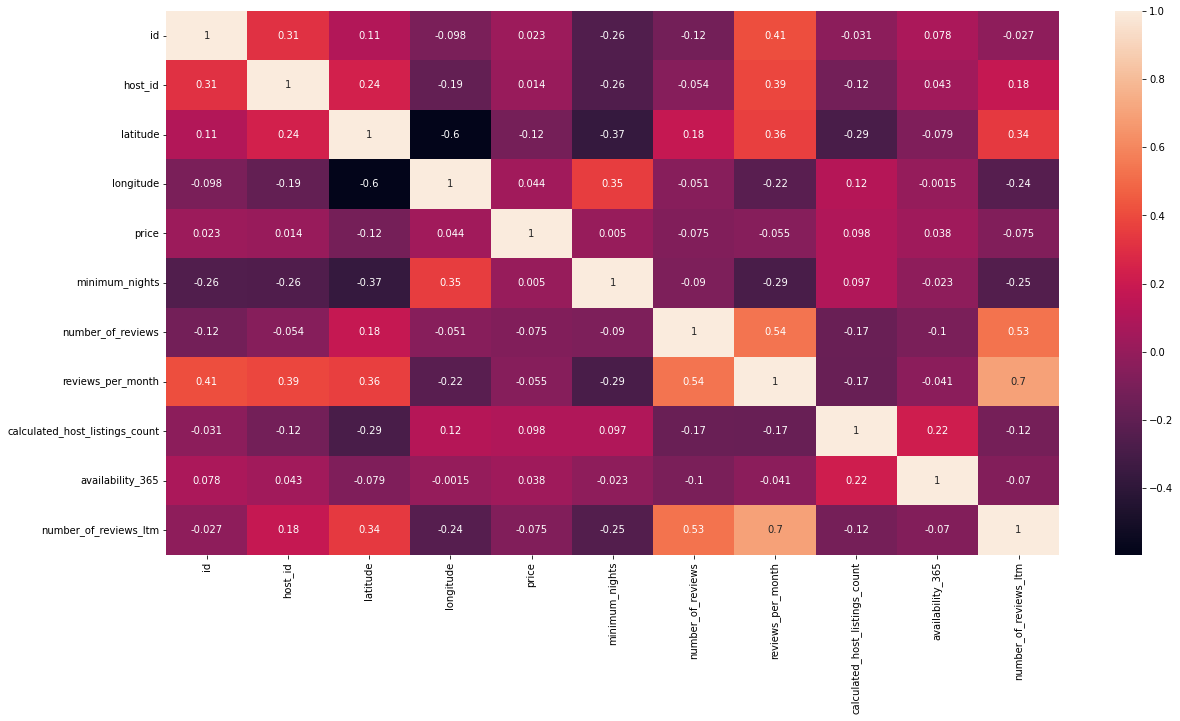

In [3]:
# correlation in lst dataframe
plt.figure(figsize=(20,10))
sns.heatmap(lst.corr(),annot=True)
plt.show()

# Data Cleaning

**Calendar (cld)**

In [4]:
# check duplicated & null values for each column
print('Number of Duplicated values =',cld.duplicated().sum())
print('-'*50)
print(cld.isna().sum())

Number of Duplicated values = 0
--------------------------------------------------
listing_id          0
date                0
available           0
price             171
adjusted_price    171
minimum_nights      0
maximum_nights      0
dtype: int64


In [5]:
# fill price,adjusted_price base on lst dataframe, in case price = adjusted_price
def fill_pri(x):
  if x['listing_id'] in lst['id'].values:
    return lst[lst['id']==x['listing_id']]['price'].values[0]

for i in 'price','adjusted_price':
  cld.loc[cld[i].isna(),i]=cld[cld[i].isna()].apply(fill_pri,axis=1)

In [6]:
# change date to datetime type
cld['date']=pd.to_datetime(cld['date'])

**Review (cmt)**

In [7]:
# check duplicated values & null values
print('Number of duplicated values =',cmt.duplicated().sum())
print('-'*50)
print(cmt.isna().sum())

Number of duplicated values = 0
--------------------------------------------------
listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         16
dtype: int64


In [8]:
# remove duplicate & null values
cmt.dropna(inplace=True)
cmt.drop_duplicates(inplace=True)

# remove unnecessary columns
cmt.drop(columns=['reviewer_name'],inplace=True)

# change date to datetime type
cmt['date']=pd.to_datetime(cmt['date'])

# clean text in comments

def clean_text(x):
    return re.sub("<br/>|[^a-zA-Z ]", " ", x).lower()
cmt['comments']=cmt['comments'].apply(clean_text)

**Lists(lst)**

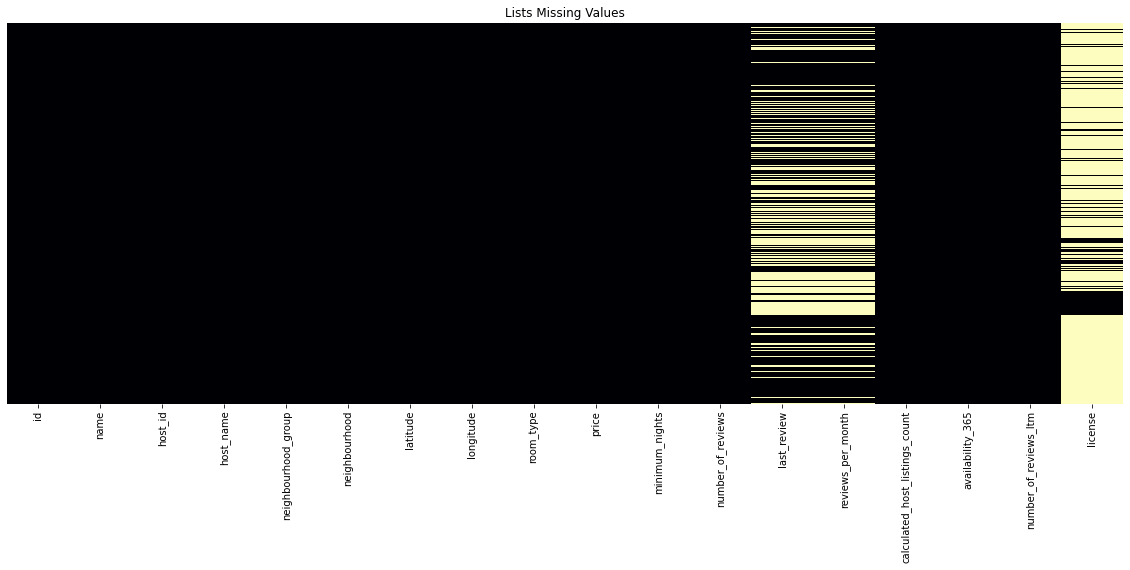

In [9]:
#check nah values
plt.figure(figsize=(20,7))
sns.heatmap(lst.isnull(),yticklabels=False,cbar=False,cmap='magma')
plt.title('Lists Missing Values')
plt.show()

In [10]:
# drop unnecessary columns
lst.drop(columns=['host_name','license','last_review','reviews_per_month'],inplace=True)

# dropna and check again
lst.dropna(inplace=True)
lst.isna().sum()

id                                0
name                              0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

In [11]:
# let check if all the lists in the right location
fig=px.scatter_mapbox(lst,center={'lat':1.35,'lon':103.8},
                      lat='latitude',lon='longitude',
                      zoom=10.4,height=700,width=1200)
fig.update_layout(mapbox_style="stamen-terrain")
fig.show()

*As we can see from the map above the data in Singapore have some lists in Malaysia --> Remove it*

In [12]:
# remove lists outside of Singapore by lattitude & longtitude
tmp=lst[lst['id']==20791161]
lst=lst[(lst['latitude']<1.4526) & (lst['longitude']>103.6627)]
lst=lst.append(tmp)
lst=lst[lst['id']!=540170321699689740]
lst.drop(labels=[2432],inplace=True)

# let check the location again
fig=px.scatter_mapbox(lst,center={'lat':1.35,'lon':103.8},
                      lat='latitude',lon='longitude',
                      zoom=10.4,height=700,width=1200)
fig.update_layout(mapbox_style="stamen-terrain")
fig.show()

In [13]:
# overview lists count in map
lat_long=list(zip(lst['latitude'].tolist(),lst['longitude'].tolist()))
map=folium.Map(location=[1.343767,103.817390], zoom_start=12)
FastMarkerCluster(data=lat_long).add_to(map)
map

# Exploratory Data Analysis and Virtualization

**High performer it has reviews number more than 90 percentile of top reviews number of total lists**

**Low performer it has reviews number less than 10 percentile of top reviews number of total lists**

--> Compare 2 listings type to find out the diferrences

In [14]:
# create new columns with high & low performance lists
lst.sort_values('number_of_reviews',ascending=False,inplace=True)
lst=(lst.reset_index()).reset_index().drop(columns='index').rename(columns={'level_0':'stt'})
top_lst=lst[lst['number_of_reviews']>=lst['number_of_reviews'].quantile(0.9)]
low_lst=lst[lst['number_of_reviews']<=lst['number_of_reviews'].quantile(0.1)]

def list_eva(x):
  if x>=lst['number_of_reviews'].quantile(0.9):
    return 'top_list'
  if x<=lst['number_of_reviews'].quantile(0.1):
    return 'low_list'
lst['list_eva']=lst['number_of_reviews'].apply(list_eva)
print('Number of top listings :',top_lst.shape[0])
print('Number of low listings :',low_lst.shape[0])

Number of top listings : 327
Number of low listings : 1455


## Accommodates

In [15]:
# create accomodates dataframe
acc=pd.merge(lst[['id','list_eva']],lst_scr[['id','accommodates']],on='id',how='left')

In [16]:
# create new columns acc_type base on accommodates (Solo, Couple, Group)
def acc_type(x):
  if x==1:
    return 'Solo'
  elif x==2:
    return 'Couple'
  elif x>2:
    return 'Group'
acc['acc_type']=acc['accommodates'].apply(acc_type)

In [17]:
acc_grb=acc.groupby(['list_eva','acc_type']).count()['id'].reset_index().rename(columns={'id':'count'})
# because low performers have more lists than high performers
# to be fair we need to calculate based on 100 scales. Ex: Couple = 38 --> 100 lists that have 38 couple room
def acc_change(x):
  if x['list_eva']=='low_list':
    return round(x['count']/low_lst.shape[0]*100)
  if x['list_eva']=='top_list':
    return round(x['count']/top_lst.shape[0]*100)
acc_grb['count']=acc_grb.apply(acc_change,axis=1)

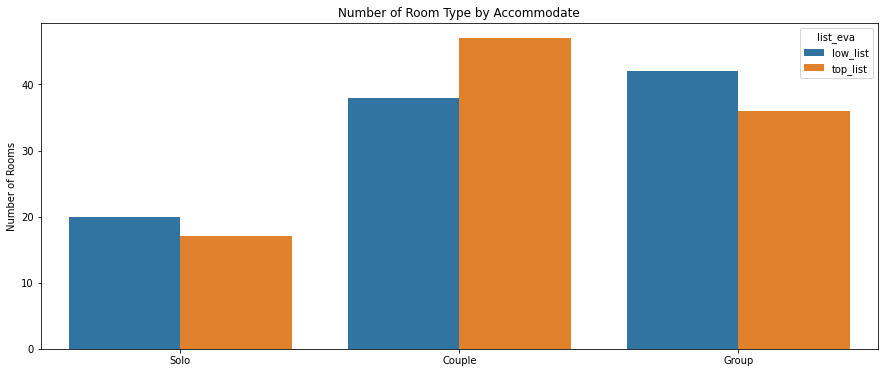

In [18]:
# plot acc_grb by barplot
plt.figure(figsize=(15,6))
sns.barplot(data=acc_grb,
             x='acc_type',
             y='count',
             hue='list_eva',order=['Solo','Couple','Group'])
plt.xlabel('')
plt.ylabel('Number of Rooms')
plt.title('Number of Room Type by Accommodate')
plt.show()

***--> High performer with more couple room. Low performer with more group room***




## Roomtype & Price

### Roomtype

In [19]:
# create room type as new dataframe
rtype=lst[['id','list_eva','room_type']]

rtype_count=rtype.groupby(['room_type','list_eva']).count()['id'].reset_index().rename(columns={'id':'count'})

In [20]:
# change count in rtype_count based on 100 scale
def rtype_count_new(x):
  if x['list_eva']=='low_list':
    return round(x['count']/low_lst.shape[0]*100)
  if x['list_eva']=='top_list':
    return round(x['count']/top_lst.shape[0]*100)
rtype_count['count']=rtype_count.apply(rtype_count_new,axis=1)

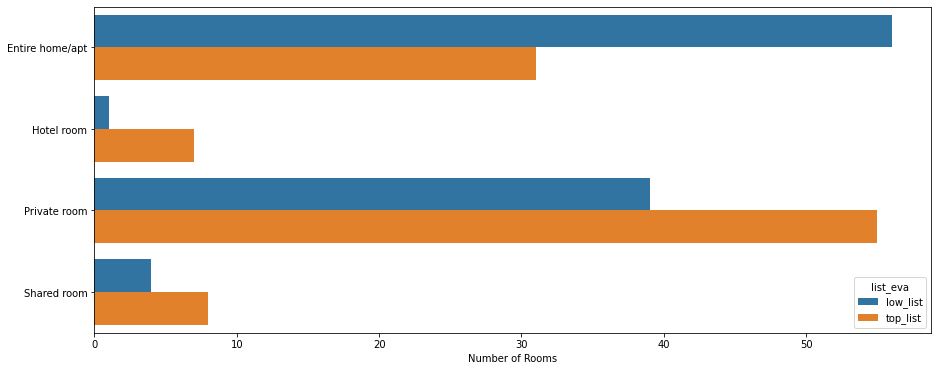

In [21]:
plt.figure(figsize=(15,6))
sns.barplot(data=rtype_count,
            y='room_type',
            x='count',
            hue='list_eva')
plt.ylabel('')
plt.xlabel('Number of Rooms')
plt.show()

***--> High performer has more private room. Low performer has more entire home/apt***

***--> Customers interested in private room more than entire home/apt***

### Price

In [22]:
# create price dataframe
prc=lst[['id','room_type','price','list_eva']]

<AxesSubplot:xlabel='price'>

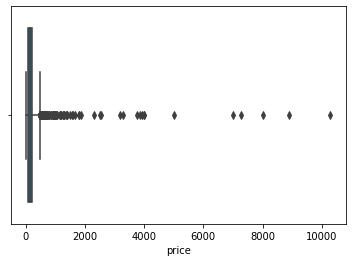

In [23]:
# overview the price
sns.boxplot(data=prc,x='price')

*There are lots of outliner in price as above image*

In [24]:
# remove outlier

# 1. Calculate the quantiles 
q1 = prc['price'].quantile(0.25) # Tính Q1
q3 = prc['price'].quantile(0.75) # Tính Q3 
# 2. Calculate the interquartile range
iqr = q3 - q1
# 3. Calculate the whisker
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

prc=prc[prc['price']<upper]

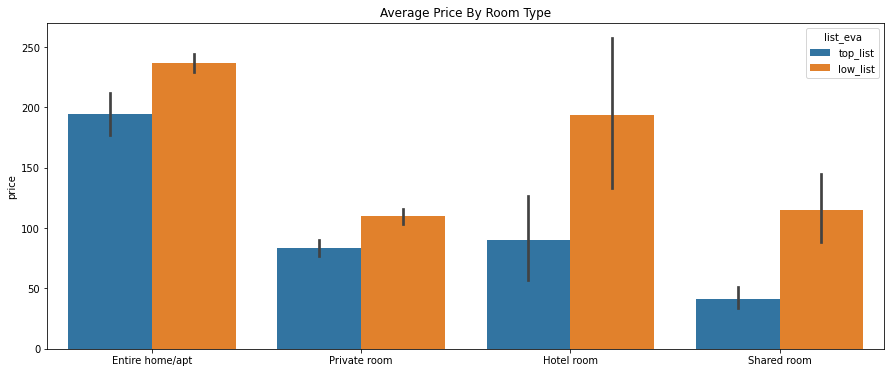

In [25]:
plt.figure(figsize=(15,6))
sns.barplot(data=prc,
             x='room_type',
             y='price',
             hue='list_eva')
plt.xlabel('')
plt.title('Average Price By Room Type')

plt.show()

***--> High performer with lower price than low performer***

## Amenity

In [26]:
# create amenity dataframe
amen=pd.merge(lst[['id','list_eva']],lst_scr[['id','amenities']],on='id',how='left')

# function to calculate the number of amenities
def amen_count(x):
  return len(x.split(','))
amen['amen_count']=amen['amenities'].apply(amen_count)

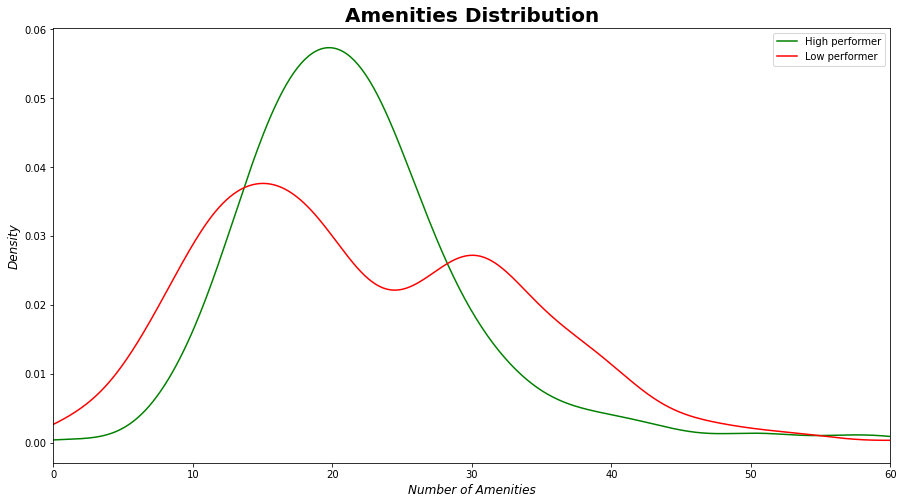

In [27]:
# amentities count by density plot
plt.figure(figsize=(15,8))
amen[amen['list_eva'].isin(['top_list'])]['amen_count'].plot(kind='kde',legend=True,color='green')
amen[amen['list_eva'].isin(['low_list'])]['amen_count'].plot(kind='kde',legend=True,color='red')
plt.xlim(0,60)
plt.xlabel('Number of Amenities',fontsize=12,style='italic')
plt.ylabel('Density',fontsize=12,style='italic')
plt.legend(['High performer', 'Low performer'])
plt.title('Amenities Distribution',fontsize=20,fontweight="bold")
plt.show()

***--> We can not attract more customers by too much or too many amenities. 20 is enough***

In [28]:
# count amenities
amen_dic={}
def amen_wrd_count(x):
  x=re.sub('''\[|\]||"''','',x)
  x=x.lower()
  for i in x.split(','):
    if i not in amen_dic:
      amen_dic[i]=1
    else:
      amen_dic[i]+=1

In [29]:
#count amenity of top lists
amen_dic={}
amen[amen['list_eva']=='top_list']['amenities'].apply(amen_wrd_count)
top_amen=pd.Series(amen_dic).reset_index().sort_values(0,ascending=False).rename(columns={0:'top_amen'})
top_amen['top_amen']=round(top_amen['top_amen']/amen[amen['list_eva']=='top_list'].shape[0]*100)

#count amenity of low lists
amen_dic={}
amen[amen['list_eva']=='low_list']['amenities'].apply(amen_wrd_count)
low_amen=pd.Series(amen_dic).reset_index().sort_values(0,ascending=False).rename(columns={0:'low_amen'})
low_amen['low_amen']=round(low_amen['low_amen']/amen[amen['list_eva']=='low_list'].shape[0]*100)

In [30]:
# find out the difference between high & low-performance listings (diff)
amen_diff=pd.merge(top_amen,low_amen,how='inner',on='index')
amen_diff['diff']=amen_diff['top_amen']-amen_diff['low_amen']
amen_diff=amen_diff[amen_diff['diff']!=0].sort_values('diff',ascending=False)
amen_diff[:15]

,index,top_amen,low_amen,diff
6,shampoo,81.0,44.0,37.0
3,hair dryer,91.0,58.0,33.0
8,hot water,79.0,57.0,22.0
15,lock on bedroom door,46.0,27.0,19.0
2,essentials,93.0,76.0,17.0
25,carbon monoxide alarm,27.0,12.0,15.0
5,iron,84.0,69.0,15.0
17,first aid kit,43.0,28.0,15.0
21,luggage dropoff allowed,37.0,22.0,15.0
29,host greets you,24.0,9.0,15.0


## Host

### Since

In [31]:
# create host dataframe
host=pd.merge(lst[['id','list_eva']],
              lst_scr[['id','host_id','host_since',
              'host_about','host_response_time',
              'host_response_rate','host_acceptance_rate',
              'host_is_superhost','host_identity_verified',
              'host_total_listings_count']],
              how='left',
              on='id')

In [32]:
# change host_since to datetime type & remove duplicate
host['host_since']=pd.to_datetime(host['host_since'])
host.drop_duplicates(subset='host_id',inplace=True)

In [33]:
host_snc=host.groupby(['list_eva',host['host_since'].dt.year]).count()['host_id'].reset_index().rename(columns={'host_id':'count'})
def snce_change(x):
  if x['list_eva']=='low_list':
    return round(x['count']/(host_snc[host_snc['list_eva']=='low_list']['count'].sum())*100,2)
  if x['list_eva']=='top_list':
    return round(x['count']/(host_snc[host_snc['list_eva']=='top_list']['count'].sum())*100,2)
host_snc['count']=host_snc.apply(snce_change,axis=1)

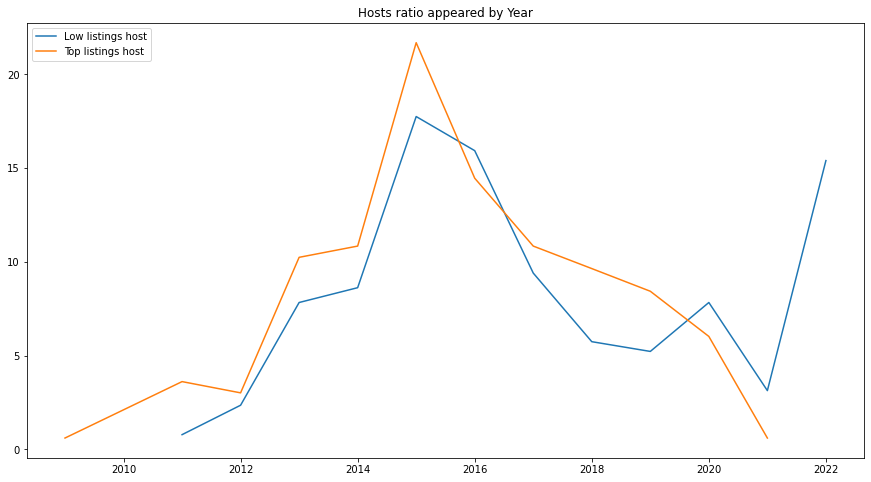

In [34]:
plt.figure(figsize=(15,8))
sns.lineplot(data=host_snc,
             x='host_since',
             y='count',
             hue='list_eva',
             legend=False)
plt.ylabel('')
plt.xlabel('')
plt.title('Hosts ratio appeared by Year')
plt.legend(loc='upper left', labels=['Low listings host','Top listings host'])
plt.show()

### Response Time

In [35]:
host_res=host[~host['host_response_time'].isna()].groupby(['list_eva','host_response_time']).count()['id'].reset_index()

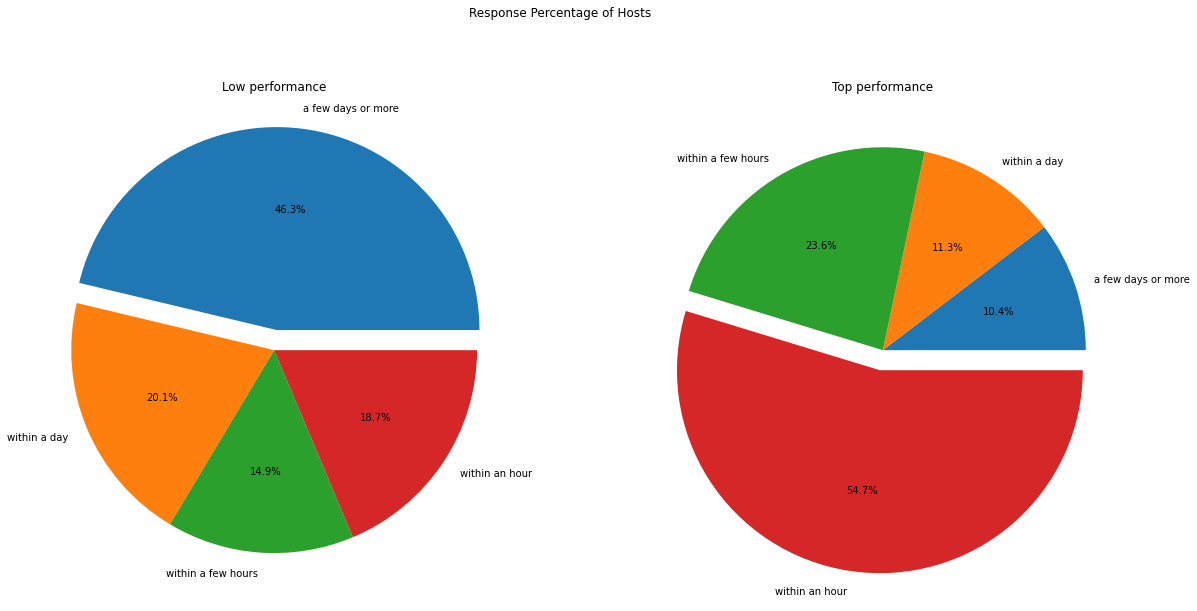

In [36]:
plt.figure(figsize=(20,10))
plt.suptitle('Response Percentage of Hosts')
plt.subplot(121)
plt.pie(host_res[host_res['list_eva']=='low_list']['id'].values,
        labels=host_res[host_res['list_eva']=='low_list']['host_response_time'],
        autopct='%1.1f%%',
        explode=(0.1,0,0,0))
plt.title('Low performance')

plt.subplot(122)
plt.pie(host_res[host_res['list_eva']=='top_list']['id'].values,
       labels=host_res[host_res['list_eva']=='top_list']['host_response_time'].values,
        autopct='%1.1f%%',
        explode=(0,0,0,0.1))
plt.title('Top performance')

plt.show()

***--> The more quickly reply, the more customers they have***

### Instant bookable & Host is Superhost & Host Identity Verified*

In [37]:
# create host dataframe
host=pd.merge(host,lst_scr[['id','instant_bookable']],how='left',on='id')

In [38]:
def host_biary(x):
  if x=='f':
    return 0
  if x=='t':
    return 1
host['host_is_superhost']=host['host_is_superhost'].apply(host_biary)
host['host_identity_verified']=host['host_identity_verified'].apply(host_biary)
host['instant_bookable']=host['instant_bookable'].apply(host_biary)

host3biary=host.groupby('list_eva').mean()[['host_is_superhost','instant_bookable','host_identity_verified']]

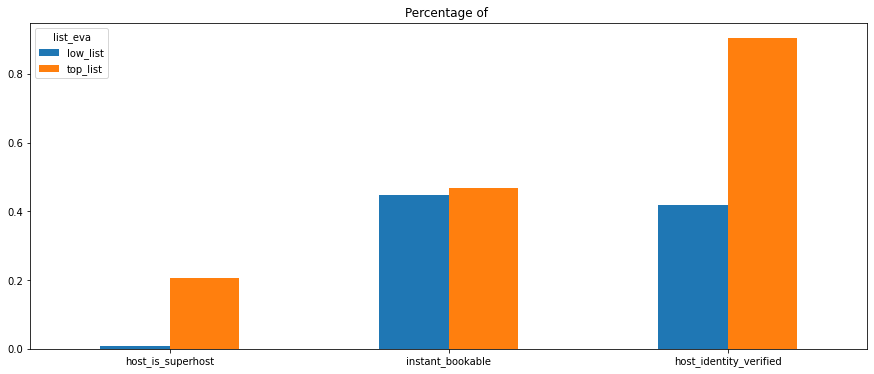

In [39]:
# set title again
host3biary.transpose().plot(kind='bar',
                            figsize=(15,6),
                            rot=0,
                            title='Percentage of ')
plt.show()

***--> Host become superhost, verified & has instant bookable have a plus***

## Response rate & Acceptance rate

In [40]:
# cleanning data
host['host_response_rate']=host['host_response_rate'].replace('%','',regex=True).astype(float)
host['host_acceptance_rate']=host['host_acceptance_rate'].replace('%','',regex=True).astype(float)

# create new response & acceptance dataframes
res_acc=host[['host_id','list_eva','host_response_rate','host_acceptance_rate']]

<AxesSubplot:xlabel='host_acceptance_rate', ylabel='Percent'>

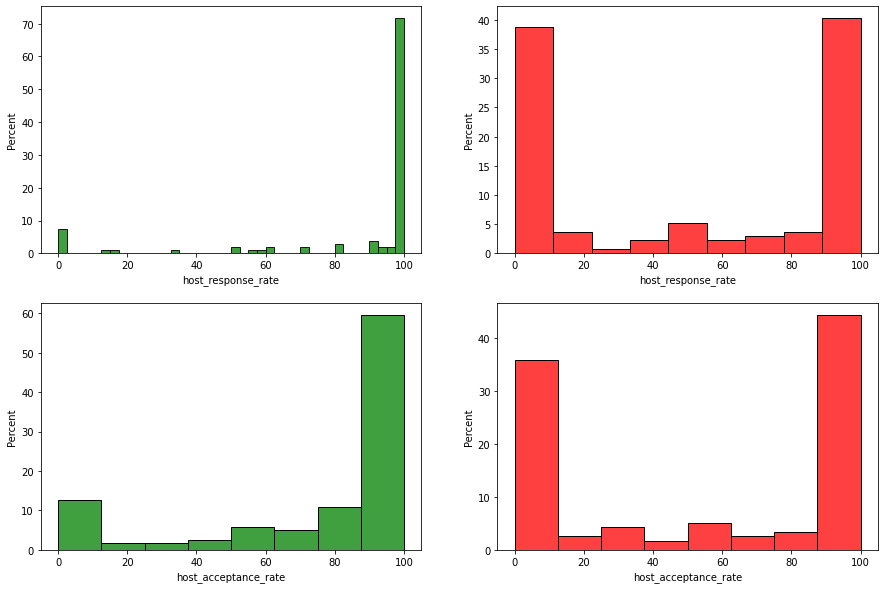

In [41]:
plt.figure(figsize=(15,10))
plt.suptitle('')
plt.subplot(221)
sns.histplot(data=res_acc[res_acc['list_eva']=='top_list'],
             x='host_response_rate',stat='percent',color='green')
plt.subplot(222)
sns.histplot(data=res_acc[res_acc['list_eva']=='low_list'],
             x='host_response_rate',stat='percent',color='red')
plt.subplot(223)
sns.histplot(data=res_acc[res_acc['list_eva']=='top_list'],
             x='host_acceptance_rate',stat='percent',color='green')
plt.subplot(224)
sns.histplot(data=res_acc[res_acc['list_eva']=='low_list'],
             x='host_acceptance_rate',stat='percent',color='red')

In [42]:
# calculate how many percent of lists that higher than 90% of acceptance & response rate

top_res=res_acc[res_acc['list_eva']=='top_list'][['list_eva','host_response_rate']].dropna()
top_res_num=top_res[top_res['host_response_rate']>90].shape[0]/top_res.shape[0]
low_res=res_acc[res_acc['list_eva']=='low_list'][['list_eva','host_response_rate']].dropna()
low_res_num=low_res[low_res['host_response_rate']>90].shape[0]/low_res.shape[0]

top_acp=res_acc[res_acc['list_eva']=='top_list'][['list_eva','host_acceptance_rate']].dropna()
top_acp_num=top_acp[top_acp['host_acceptance_rate']>90].shape[0]/top_acp.shape[0]
low_acp=res_acc[res_acc['list_eva']=='low_list'][['list_eva','host_acceptance_rate']].dropna()
low_acp_num=low_acp[low_acp['host_acceptance_rate']>90].shape[0]/low_acp.shape[0]

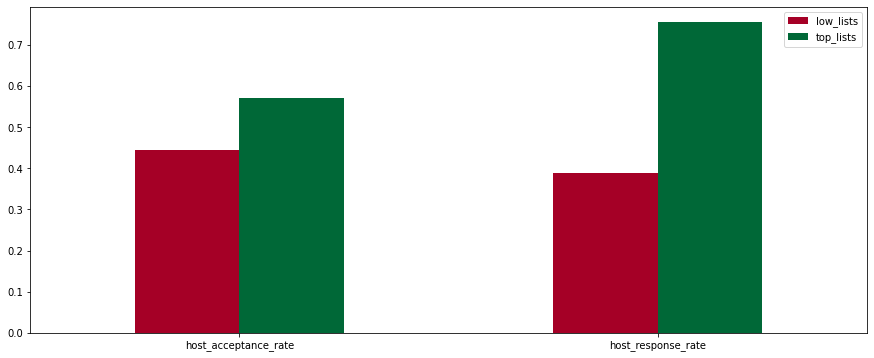

In [43]:
pd.DataFrame(data={'low_lists':[low_acp_num,low_res_num],'top_lists':[top_acp_num,top_res_num]},
             index=['host_acceptance_rate','host_response_rate']).plot(kind='bar',
                                                                       rot=0,
                                                                       figsize=(15,6),
                                                                       title=(''),
                                                                       colormap='RdYlGn')
plt.show()

***--> The more host acceptance rate & response rate the more advantages***

### Host about

In [44]:
# check host about to know if value exist or not & calculate exist ratio
host['host_about'].fillna(0,inplace=True)
def host_ab_change(x):
  if x['host_about']!=0:
    return 1
  else:
    return 0
host['host_about_biary']=host.apply(host_ab_change,axis=1)

In [45]:
host.groupby('list_eva').mean()['host_about_biary']

list_eva
low_list    0.305483
top_list    0.622754
Name: host_about_biary, dtype: float64

In [46]:
# write the function to count word length in host_bout 
host['host_about']=host['host_about'].astype(str)
def host_about_new(x):
  x=x.lower()
  x=re.sub('[^A-Za-z1-9\s]|\r|\n','',x)
  return x
host['abt_wrd_new']=host['host_about'].apply(host_about_new)
def host_about_count(x):
  return len(x.split())
host['abt_wrd_count']=host['abt_wrd_new'].apply(host_about_count)

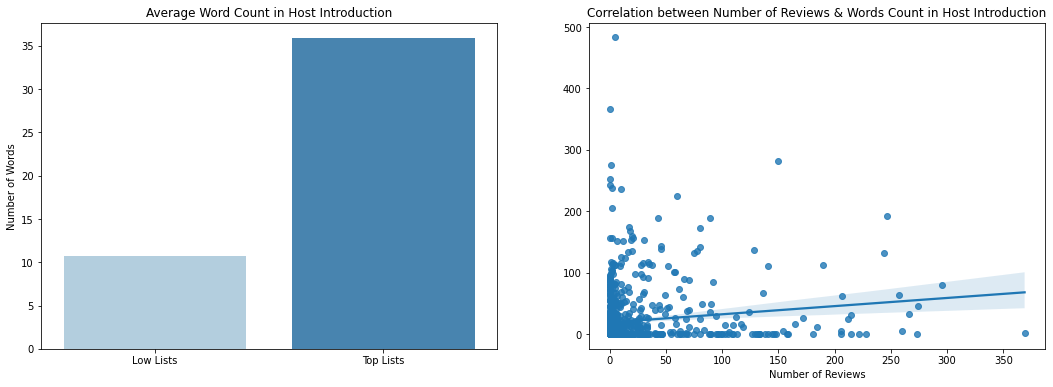

In [47]:
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.barplot(data=host.groupby('list_eva').mean()['abt_wrd_count'].reset_index(),
            x='list_eva',
            y='abt_wrd_count',
            palette="Blues")
plt.ylabel('Number of Words')
plt.xlabel('')
plt.title('Average Word Count in Host Introduction')
plt.xticks(ticks=[0, 1],labels=['Low Lists', 'Top Lists'])
plt.subplot(122)
sns.regplot(data=pd.merge(host[['id','abt_wrd_count']],lst[['id','number_of_reviews']],
         on='id',how='inner'),
         y='abt_wrd_count',
         x='number_of_reviews')
plt.title('Correlation between Number of Reviews & Words Count in Host Introduction')
plt.ylabel('')
plt.xlabel('Number of Reviews')
plt.show()

***--> Top listings have more word counts in their introduction***

## Name & Description & Neighborhood Overview

In [48]:
nltk.download('stopwords')
stops = stopwords.words("english")
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
text3=pd.merge(lst[['id','list_eva','number_of_reviews']],
               lst_scr[['id','name','description','neighborhood_overview']],
               how='left',
               on='id')

In [50]:
# function to clean word in each column
def clean_text(x):
  x= (re.sub('[^a-zA-Z1-9\s]|</b>|<b>|<br />|<br/>|br','',x)).lower()
  if x=='nan':
    return None
  else:
    return x
for i in 'name','description','neighborhood_overview':
  text3[i]=text3[i].astype(str)
  text3[i]=text3[i].apply(clean_text)

### Occurrence Rate

In [51]:
# function to check if the description or neighborhood_overview is exist or not.
def txt_biary(x):
  if x is not None:
    return 1
  else:
    return 0
text3['desc_bia']=text3['description'].apply(txt_biary)
text3['nbhovv_bia']=text3['neighborhood_overview'].apply(txt_biary)

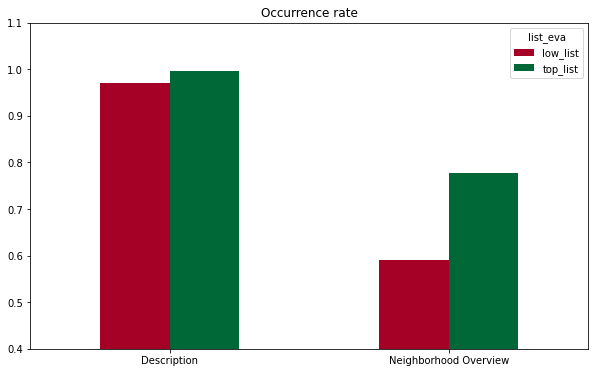

In [52]:
text3.groupby('list_eva').mean()[['desc_bia','nbhovv_bia']].transpose().plot(kind='bar',
                                                                             rot=0,
                                                                             ylim=(0.4,1.1),
                                                                             figsize=(10,6),
                                                                             colormap='RdYlGn')
plt.xticks(ticks=[0, 1],labels=['Description', 'Neighborhood Overview'])
plt.title('Occurrence rate')
plt.show()

## Word count in sentence

In [53]:
def wrd_sen_count(x):
  if x is not None:
    return len(x.split())
  else:
    return 0
text3['na_cou']=text3['name'].apply(wrd_sen_count)
text3['desc_cou']=text3['description'].apply(wrd_sen_count)
text3['neiovv_cou']=text3['neighborhood_overview'].apply(wrd_sen_count)

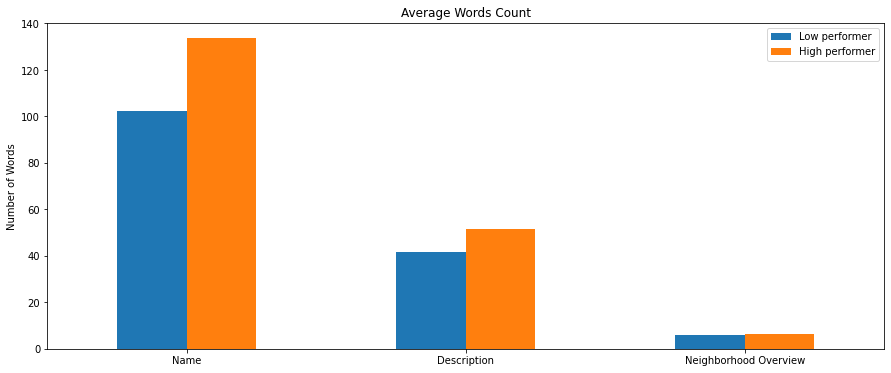

In [54]:
text3.groupby('list_eva').mean()[['na_cou','desc_cou','neiovv_cou']].transpose().sort_values('top_list',ascending=False).plot(kind='bar',figsize=(15,6))
plt.title('Average Words Count')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1,2],labels=['Name', 'Description','Neighborhood Overview'],rotation=0)
plt.legend(["Low performer", "High performer"])

plt.show()

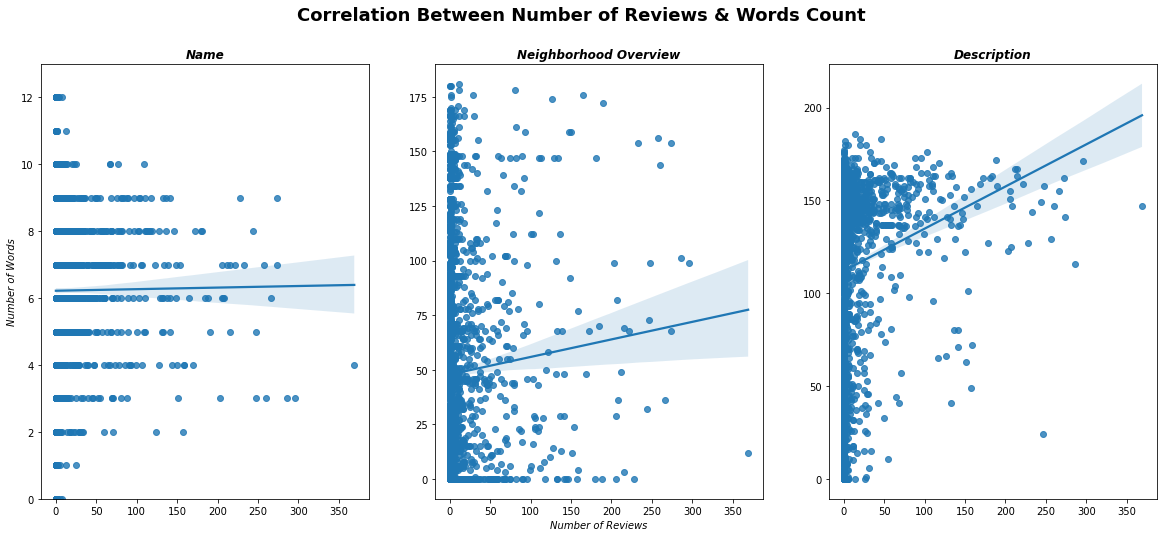

In [55]:
plt.figure(figsize=(20,8))
plt.suptitle('Correlation Between Number of Reviews & Words Count',fontweight="bold",fontsize=18)
plt.subplot(131)
sns.regplot(data=text3,x='number_of_reviews',y='na_cou')
plt.title('Name',style='italic',fontweight="bold")
plt.ylabel('Number of Words',style='italic')
plt.xlabel('')
plt.ylim(0,13)
plt.subplot(132)
plt.title('Neighborhood Overview',style='italic',fontweight="bold")
sns.regplot(data=text3,x='number_of_reviews',y='neiovv_cou')
plt.ylabel('')
plt.xlabel('Number of Reviews',style='italic')
plt.subplot(133)
plt.title('Description',style='italic',fontweight="bold")
sns.regplot(data=text3,x='number_of_reviews',y='desc_cou')
plt.ylabel('')
plt.xlabel('')

plt.show()

***--> With 2 images as above we realise that high performer with more words in Neighborhood Overview & Description***

**Words count**

In [56]:
wrd_dic={}
def wrd_count(x):
  result=[]
  for i in x.split():
    if i not in stops:
      i=porter.stem(i)
      result.append(i)
  txt=' '.join(result)
  for i in txt.split():
    if i not in wrd_dic:
      wrd_dic[i]=1
    elif i in wrd_dic:
      wrd_dic[i]+=1

In [57]:
for i in 'top_list','low_list':
  for j in 'name','description','neighborhood_overview':
    wrd_dic={}
    text3[text3['list_eva']==i][j].dropna().apply(wrd_count)
    tmp=pd.Series(wrd_dic).sort_values(ascending=False).reset_index()
    tmp.rename(columns={0:i,'index':'word'},inplace=True)
    tmp[i]=round(tmp[i]/text3[text3['list_eva']==i].shape[0]*100)
    tmp=tmp[tmp[i]!=0]
    if i=='top_list' and j =='name':
      top_name=tmp
    elif i=='top_list' and j =='description':
      top_desc=tmp
    elif i=='top_list' and j=='neighborhood_overview':
      top_neiovv=tmp
    elif i=='low_list' and j =='name':
      low_name=tmp
    elif i=='low_list' and j =='description':
      low_desc=tmp
    elif i=='low_list' and j=='neighborhood_overview':
      low_neiovv=tmp

In [58]:
a=0
for i in [[top_name,low_name],[top_neiovv,low_neiovv],[top_desc,low_desc]]:
  tmp=pd.merge(i[0],i[1],how='inner',on='word')
  tmp['word_diff']=tmp['top_list']-tmp['low_list']
  tmp=tmp.sort_values('word_diff',ascending=False)
  if a==0:
    diff_name=tmp
  if a==1:
    diff_nei=tmp
  if a==2:
    diff_desc=tmp
  a=a+1

In [59]:
diff_desc[:30].sample(30).to_csv('test.csv')

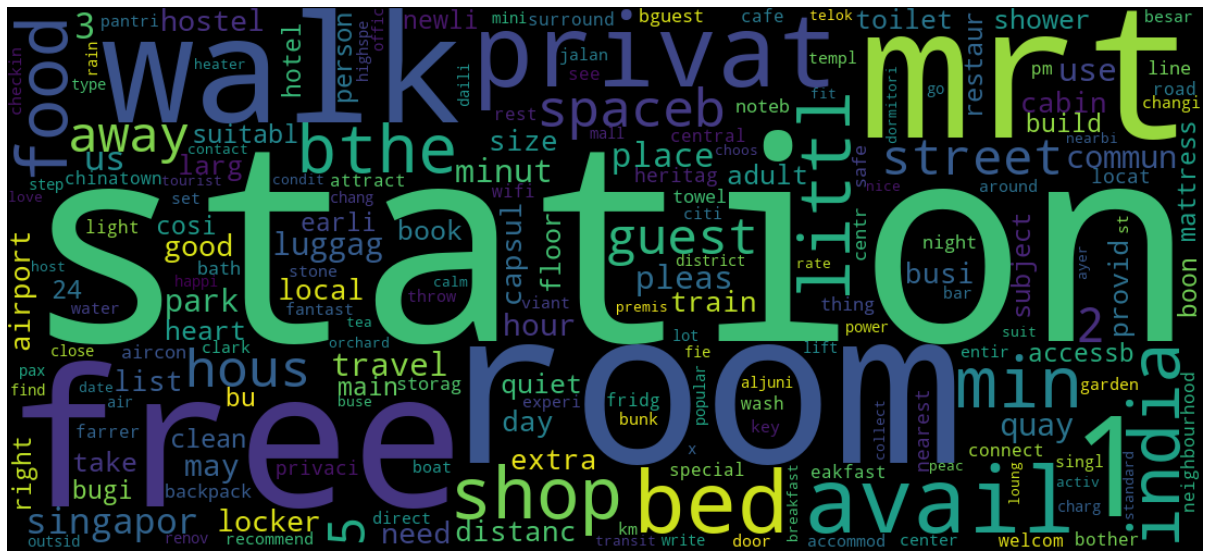

In [60]:
# description
wordcloud = WordCloud(width=1100, height=500)
wordcloud.generate_from_frequencies(frequencies=diff_desc[['word','word_diff']].set_index('word').to_dict()['word_diff'])
plt.figure(figsize=(25,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()

***--> station, mrt, walk, shop, min, train, food --> Near mrt station, food shop, convenient store that people dont need to walk so far***

***--> free & private --> people need more privacy in there place***

In [61]:
# neighborhood_overview
diff_nei['word']=diff_nei['word'].astype(str)
diff_nei['word_diff']=diff_nei['word_diff'].astype(int)
diff_nei=diff_nei[diff_nei['word_diff']>0][:50]
norm = matplotlib.colors.Normalize(vmin=min(diff_nei['word_diff']), vmax=max(diff_nei['word_diff']))
colors = [matplotlib.cm.Blues(norm(value)) for value in diff_nei['word_diff']]

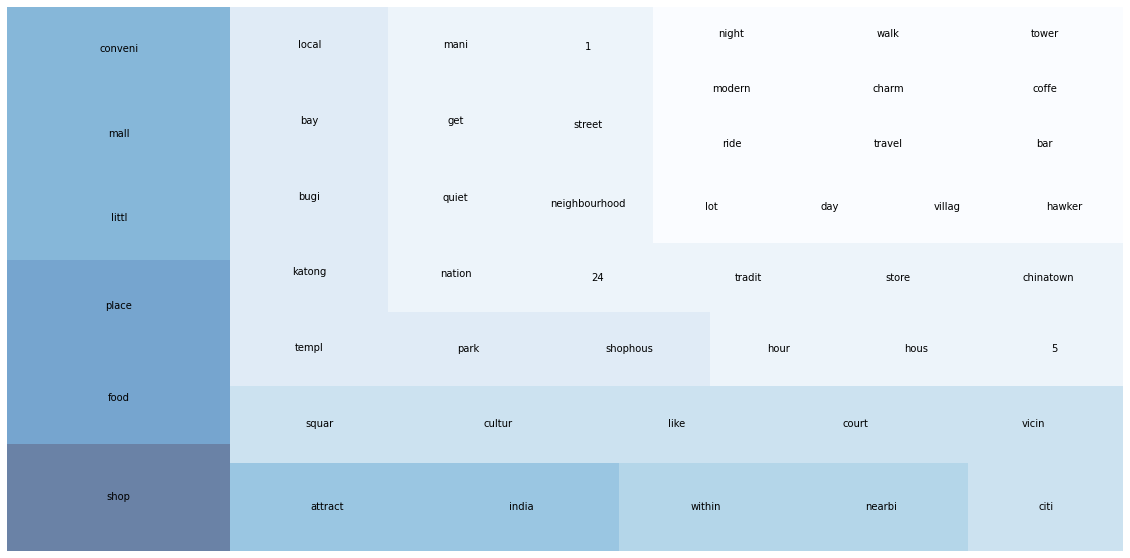

In [62]:
# plot neighborhood_overview in treemap. The more darker colors, the more count in words
plt.figure(figsize=(20,10))
squarify.plot(label=diff_nei['word'],sizes=diff_nei['word_diff'], color = colors, alpha=.6)
plt.axis('off')
plt.title("",fontsize=23,fontweight="bold")
plt.show()

***--> shop, food, mall, conveni, nearby --> shop food, convenient store nearby that people dont need to walk so far***

In [63]:
diff_name['word']=diff_name['word'].astype(str)
diff_name['word_diff']=diff_name['word_diff'].astype(int)
diff_name=diff_name[diff_name['word_diff']>0][:20]

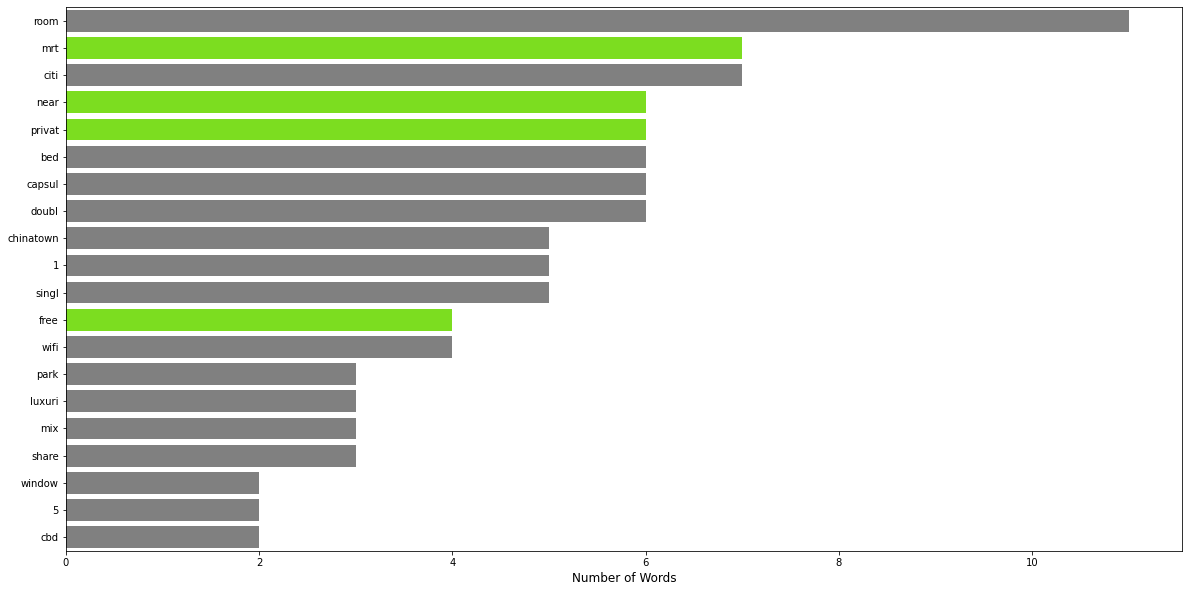

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=diff_name[:20]['word_diff'],
            y=diff_name[:20]['word'],
            ax=ax,
            palette={c: "grey" if c not in ['mrt','near','privat','free'] else "lawngreen" for c in diff_name['word'].unique()})
ax.set_ylabel('')
ax.set_xlabel('Number of Words', fontsize=12)
ax.set_title('')
plt.show()

***--> mrt, near, private, free --> need privacy, convenient place nearby***

## Location

In [65]:
loc_count=lst.groupby(['list_eva','neighbourhood']).count()['id'].reset_index().rename(columns={'id':'count'})

In [66]:
def nei_change(x):
  if x['list_eva']=='low_list':
    return round(x['count']/lst[lst['list_eva']=='low_list'].shape[0]*100,2)
  elif x['list_eva']=='top_list':
    return round(x['count']/lst[lst['list_eva']=='top_list'].shape[0]*100,2)
loc_count['count']=loc_count.apply(nei_change,axis=1)

In [67]:
loc_gap=pd.merge(loc_count[loc_count['list_eva']=='low_list'].rename(columns={'count':'low_list'}).drop(columns='list_eva'),
         loc_count[loc_count['list_eva']=='top_list'].rename(columns={'count':'top_list'}).drop(columns='list_eva'),
         on='neighbourhood',
         how='inner')
loc_gap['gap']=(loc_gap['top_list']-loc_gap['low_list'])
loc_gap=loc_gap.sort_values('gap',ascending=False)

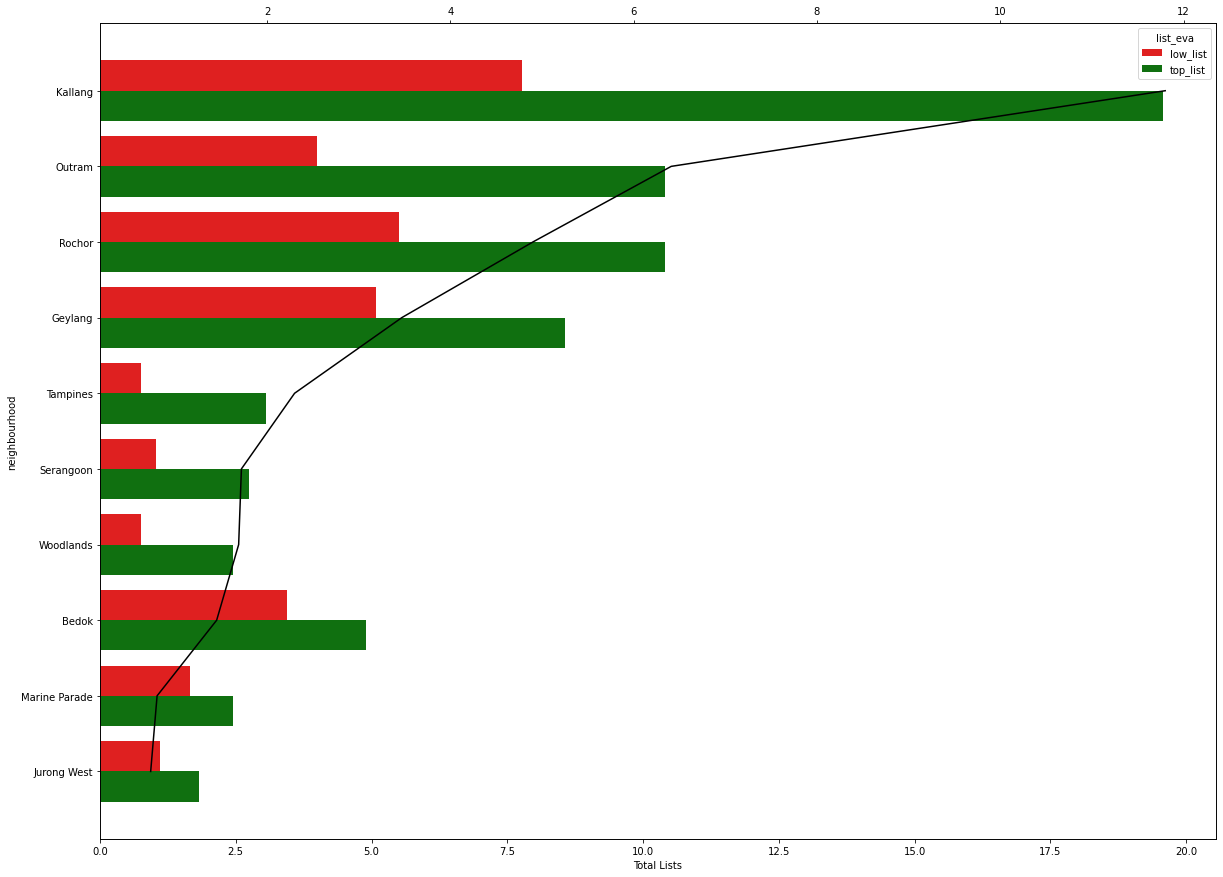

In [68]:
plt.figure(figsize=(20,15))
sns.barplot(data=loc_count[loc_count['neighbourhood'].isin(loc_gap[:10]['neighbourhood'].unique())],
            y='neighbourhood',
            x='count',
            hue='list_eva',
            order=loc_gap[:10]['neighbourhood'].unique(),
            palette=['red','green'])
plt.xlabel('Total Lists')
plt.twiny()
sns.lineplot(data=loc_gap[:10],x='gap',y='neighbourhood',color='black')
plt.xlabel('')

plt.show()

# Conclusion & Solution

Compare 2 types of listings 💞
-   High-performance listings
  - Have more couple rooms for 2 peoples & private rooms
  - Average price is lower than Low-performance listings about 50$ --> Reasonable room price is between 50 to 200 depending on room types
  - More words count in Neighborhood Overview(~50 words) & Description (100-150 words)
  - Near the MRT station, food shop, a convenience store where people do not need to walk so far
  - Offer free stuff --> People need more free things like free parking, free wifi
-   Low-performance listings
  -   They have more group rooms (more than 3 people) & entire home/apt

More insights 💕
1. We can not attract more customers with too much or too many amenities. 15 - 20 amenities are enough
2. Host become super host, verified & has instantly bookable is a plus
3. The more quickly reply, host acceptance rate & response rate the more customers they have